In [1]:
import numpy as np
import os
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import joblib
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# --- Configurações Iniciais ---
TICKER_PARA_TREINAR = "PETR4.SA"
CAMINHO_DADOS_PROCESSADOS = "../data/03_processed"
CAMINHO_MODELOS = "../models"

print("Bibliotecas importadas e configurações prontas.")

2025-10-31 00:48:30.186173: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-10-31 00:48:30.323526: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/marolli/Projetos/TCC_2025/.venv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/home/marolli/Projetos/TCC_2025/.venv/lib64/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one

Bibliotecas importadas e configurações prontas.


In [2]:
# Carrega os arrays do disco
X_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_X_train.npy'))
y_train = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_y_train.npy'))
X_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_X_test.npy'))
y_test = np.load(os.path.join(CAMINHO_DADOS_PROCESSADOS, f'{TICKER_PARA_TREINAR}_y_test.npy'))

# Verifica os formatos para garantir que tudo foi carregado corretamente
print("Formatos dos dados carregados:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

Formatos dos dados carregados:
X_train shape: (5129, 60, 1)
y_train shape: (5129,)
X_test shape: (1238, 60, 1)
y_test shape: (1238,)


In [3]:
# Usaremos um modelo Sequencial, que é uma pilha linear de camadas.
model = Sequential()

# JEITO NOVO E RECOMENDADO: Camada de Input dedicada para definir o formato da entrada
model.add(Input(shape=(X_train.shape[1], 1)))

# Camada 1: A primeira camada LSTM (não precisa mais do 'input_shape')
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

# Camada 2: A segunda camada LSTM
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))

# Camada 3: Uma camada Densa (tradicional)
model.add(Dense(units=25))

# Camada 4: A Camada de Saída
model.add(Dense(units=1))

print("Arquitetura do modelo construída.")

Arquitetura do modelo construída.


2025-10-31 00:48:34.852447: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [4]:
# Compila o modelo, configurando o otimizador e a função de erro
model.compile(optimizer='adam', loss='mean_squared_error')

# Mostra um resumo da arquitetura do modelo
model.summary()

# Configura o Early Stopping para monitorar o erro de validação (val_loss)
# Ele vai parar o treino se não houver melhora por 5 épocas seguidas
# e restaurará os melhores pesos encontrados.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("\nModelo compilado e callback de Early Stopping configurado.")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)


Modelo compilado e callback de Early Stopping configurado.


In [5]:
print("\nIniciando o treinamento do modelo...")

# Aumentamos o número de épocas para 100, mas o Early Stopping
# provavelmente irá parar o treinamento bem antes, no ponto ideal.
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping] # Passamos o callback aqui
)

print("\nTreinamento concluído!")


Iniciando o treinamento do modelo...
Epoch 1/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0049 - val_loss: 0.1208
Epoch 2/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0016 - val_loss: 0.1071
Epoch 3/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0013 - val_loss: 0.1243
Epoch 4/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.0012 - val_loss: 0.0643
Epoch 5/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0012 - val_loss: 0.0275
Epoch 6/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0011 - val_loss: 0.0307
Epoch 7/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 9.9668e-04 - val_loss: 0.0307
Epoch 8/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 9.8629e-04 - val_loss: 0.0237
Epoch 9/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 9.7519e-04 - val_loss: 0.0319
Epoch 10/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - loss: 9.6509e-04 - val_loss: 0.0607
Epoch 11/100
161/161 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - loss: 9.

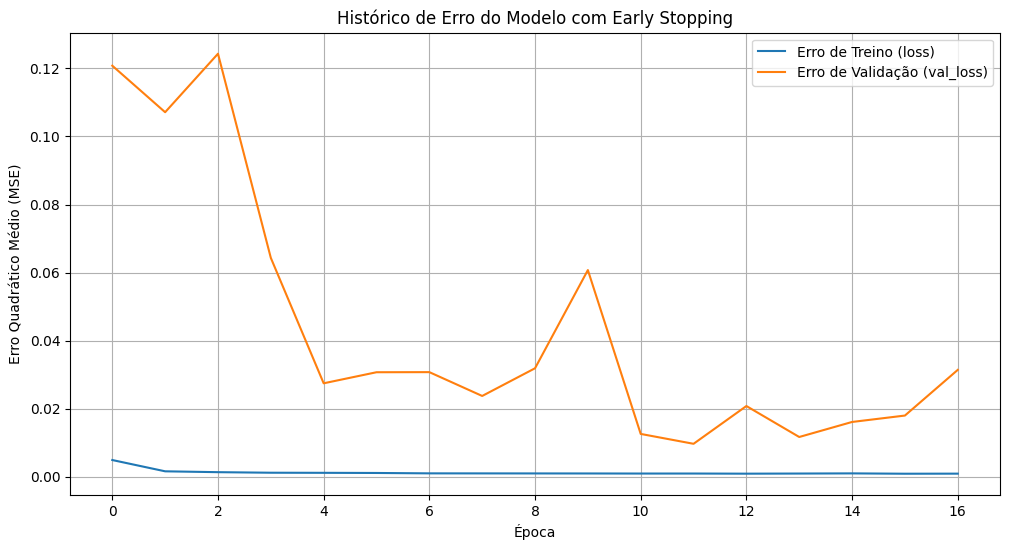


Melhor modelo salvo com sucesso em: '../models/PETR4.SA_lstm_model.h5'


In [6]:
# Plota o gráfico de erro para vermos como o modelo aprendeu
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Erro de Treino (loss)')
plt.plot(history.history['val_loss'], label='Erro de Validação (val_loss)')
plt.title('Histórico de Erro do Modelo com Early Stopping')
plt.xlabel('Época')
plt.ylabel('Erro Quadrático Médio (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Salva o modelo final (que já está com os melhores pesos graças ao Early Stopping)
caminho_modelo_salvo = os.path.join(CAMINHO_MODELOS, f"{TICKER_PARA_TREINAR}_lstm_model.h5")
model.save(caminho_modelo_salvo)

print(f"\nMelhor modelo salvo com sucesso em: '{caminho_modelo_salvo}'")

In [7]:
# Salva o modelo treinado na pasta 'models'
caminho_modelo_salvo = os.path.join(CAMINHO_MODELOS, f"{TICKER_PARA_TREINAR}_lstm_model.h5")
model.save(caminho_modelo_salvo)

print(f"\nModelo salvo com sucesso em: '{caminho_modelo_salvo}'")


Modelo salvo com sucesso em: '../models/PETR4.SA_lstm_model.h5'


In [8]:
# --- Bloco de Geração e Reversão da Previsão (Previsão do Próximo Passo de Tempo) ---


# Importante: O objeto 'scaler' (MinMaxScaler) deve estar carregado/disponível aqui.

# 1. Obter o dado de entrada para a previsão
# Pegamos a ÚLTIMA sequência do conjunto de teste (X_test)
# Esta sequência é a "janela de observação" mais recente conhecida pelo modelo.
ultima_sequencia_normalizada = X_test[-1]

# O modelo LSTM espera o formato (1, Tamanho da Sequência, 1).
# X_test[-1] é (Tamanho da Sequência, 1). Adicionamos a dimensão 'amostra=1' no início.
X_next_day = np.expand_dims(ultima_sequencia_normalizada, axis=0)

# 2. Fazer a previsão
# A previsão retornada está no intervalo normalizado (entre 0 e 1)
previsao_normalizada = model.predict(X_next_day, verbose=0)

# 3. Reverter a padronização
# Usamos o scaler original para transformar o valor normalizado de volta para a escala real (R$)
previsao_real = scaler.inverse_transform(previsao_normalizada)

# 4. Imprimir o resultado
valor_previsto = previsao_real[0][0]

print("\n--- Resultado da Previsão ---")
print(f"A última sequência de dados usada tinha {X_test.shape[1]} passos de tempo.")
print(f"O modelo prevê que o próximo valor de '{TICKER_PARA_TREINAR}' será de R$ {valor_previsto:.2f}")

NameError: name 'scaler' is not defined